<a href="https://colab.research.google.com/github/PauloPrudente/AnaliseSentimento/blob/main/AnaliseSentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install google-play-scraper

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-0.1.1-cp36-none-any.whl size=22260 sha256=2a04a039530fa92a8f5abcb31bd8a2f76b31d5ccfafc56de482d314227f42ef4
  Stored in directory: /root/.cache/pip/wheels/d7/1f/71/e2b30aab85297ad6dd2e3049587a6763cfb7e803a0b76d982e
Successfully built google-play-scraper


In [2]:
#Importando o comando app da library google-play-scraper
from google_play_scraper import app

In [4]:
result = app('com.rappi.storekeeper', lang = 'pt', country = 'br')
result

{'adSupported': None,
 'androidVersion': '4.4',
 'androidVersionText': '4.4 ou superior',
 'appId': 'com.rappi.storekeeper',
 'comments': [],
 'containsAds': False,
 'contentRating': 'Classificação 14 anos',
 'contentRatingDescription': 'Drogas Ilícitas',
 'currency': 'USD',
 'description': 'Ganhe dinheiro por cada entrega, sem limite de lucro!\r\n\r\n\r\nFizemos este app pensando em você! Tenha toda a informação que você precisa e coordene os seus pedidos com a palma da sua mão. \r\n\r\n<b>Novidades:</b>\r\n\r\n- Seus pedidos agora terão um passo-a-passo, permitindo maior controle do processo \r\n- Histórico com todas as informações das suas dispersões e pagamentos  \r\n- Sistema para reservar e verificar suas vagas\r\n- Canal de suporte para receber ajuda no que você precisar\r\n- Opção de ajuda para encontrar informações e novidades da Rappi\r\n- Mapa com zonas da cidade para que você conheça os lugares e as horas com maior demanda\r\n- Botão de emergência\r\n- Promoções\r\n\r\nBaix

In [5]:
#Baixando todos os reviews do app.
from google_play_scraper import Sort, reviews_all

#Comando para todas as reviews

Reviews = reviews_all( 'com.rappi.storekeeper', lang = 'pt', country = 'br', sort = Sort.MOST_RELEVANT, sleep_milliseconds = 0)

In [6]:
#Importando pandas.
import pandas as pd


#Transformando os dados em um DataFrame para trabalharmos as análises.
Reviews_Rappi = pd.DataFrame(Reviews)

#Verificando a serie de dados.
Reviews_Rappi

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHIqgCt1yzLhBd_GtovC7vsJsUZU37e_Yecj0q...,Sergio Rodio,https://play-lh.googleusercontent.com/a-/AOh14...,"O App é funcional, porém as vezes buga na ques...",1,15,6.35.2,2020-10-29 05:37:24,None,NaT
1,gp:AOqpTOE3fIi70V8gXpfplMi8N7UpKmgOnwUHft1OtFH...,Divino Ciborg,https://play-lh.googleusercontent.com/-OlIFAsl...,Cada dia mais complicado... suporte lento.. co...,1,7,6.35.2,2020-10-29 14:29:38,None,NaT
2,gp:AOqpTOGUUd0eg7m5JZujhqyXGTH90FLzVil8e73JOvA...,Bruno Pineda,https://play-lh.googleusercontent.com/a-/AOh14...,"Fiz o cadastro como pediram, porém não foi apr...",1,4,6.35.2,2020-10-29 19:47:06,None,NaT
3,gp:AOqpTOEOiEY9ltVOgoIXu2DUS6pwP1fZC5-OkrkHvqv...,josielson oliveira,https://play-lh.googleusercontent.com/a-/AOh14...,Deveria ter um limite de compra ou de itens pr...,2,40,6.35.2,2020-10-28 17:32:33,None,NaT
4,gp:AOqpTOF-EBHe9facV8dmu4E5AAp0sokv0mAEvIon1xb...,Elton Camilo de Andrade,https://play-lh.googleusercontent.com/a-/AOh14...,Um lixo.... No aplicativo mostra corrida de 4k...,1,74,6.34.3,2020-10-27 02:20:27,None,NaT
...,...,...,...,...,...,...,...,...,...,...
50303,gp:AOqpTOHjsXvORWz5Q5SuM4ofuVjuU8gLaIsa61BLIM7...,David Rodrigues Moraes,https://play-lh.googleusercontent.com/-MhMn2LT...,\o/,5,0,None,2019-12-20 00:21:58,None,NaT
50304,gp:AOqpTOE3CXi_u4_RlhzR_dVoE584pDV4X520eR__MqO...,santos santos,https://play-lh.googleusercontent.com/a-/AOh14...,É...,5,0,None,2020-02-12 16:42:20,None,NaT
50305,gp:AOqpTOFYPZkOSdLzw6-e3cHHWj7fp0jdeFPS9Idczk3...,Mizael Silva,https://play-lh.googleusercontent.com/-E1viVbd...,👏🏽👏🏽👏🏽,5,0,None,2020-09-18 00:05:24,None,NaT
50306,gp:AOqpTOEoMAY9sYQAoJftH0G5MbiAoFe4I6qnFahg3c8...,Zippersson,https://play-lh.googleusercontent.com/a-/AOh14...,💪🏿,5,0,None,2020-07-25 19:47:28,None,NaT


In [7]:
#Importando o nltk e salvando os corpus necessários

import nltk
nltk.download('wordnet')
nltk.download('punkt')

#Aplicando uma função para tokenizar por palavra

Reviews_Rappi['content'] = Reviews_Rappi.apply(lambda row: nltk.word_tokenize(row['content']), axis=1) # Tokenização dos dados

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
language = 'portuguese'

#Criando a lista de stopwords
stopwords = stopwords.words(language)
stopwords = list(set(stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def remove_stopwords(words):
    """Remover as Stopwords das palavras tokenizadas"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

In [10]:
def to_lowercase(words):
    """converter todos os caracteres para lowercase"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [12]:
def remove_punctuation(words):
    """remover pontuação"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    

    return new_words

In [13]:
def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    
    return ' '.join(words)

In [14]:
Reviews_Rappi['content'] = Reviews_Rappi.apply(lambda row: normalize(row['content']), axis=1)

In [15]:
#Importando o Léxico de Palavras com polaridades
sentilexpt = open('SentiLex-lem-PT02.txt')

#Criando um dicionário de palavras com a respectiva polaridade.
dic_palavra_polaridade = {}
for i in sentilexpt.readlines():
  pos_ponto = i.find('.')
  palavra = (i[:pos_ponto])
  pol_pos = i.find('POL')
  polaridade = (i[pol_pos+7:pol_pos+9]).replace(';', '')
  dic_palavra_polaridade[palavra] = polaridade


#Verificando o dicionário

dic_palavra_polaridade

{'à-vontade': '1',
 'abafado': '-1',
 'abafante': '-1',
 'abaixado': '-1',
 'abalado': '-1',
 'abalizado': '1',
 'abalroado': '-1',
 'abalroar': '1',
 'abanar': '1',
 'abandalhado': '-1',
 'abandalhamento': '-1',
 'abandonado': '-1',
 'abandonar': '-1',
 'abarcante': '0',
 'abarrotado': '-1',
 'abastado': '1',
 'abastecido': '0',
 'abater': '1',
 'abatido': '-1',
 'abelhudo': '-1',
 'abençoado': '1',
 'aberração': '-1',
 'aberrante': '-1',
 'aberrativo': '-1',
 'aberto': '1',
 'abespinhado': '-1',
 'abestalhado': '-1',
 'abilolado': '-1',
 'abjeção': '-1',
 'abjecção': '-1',
 'abjecto': '-1',
 'abjeto': '-1',
 'abnegado': '1',
 'abobado': '-1',
 'abobalhado': '-1',
 'abolicionista': '0',
 'abolido': '-1',
 'abominador': '-1',
 'abominando': '-1',
 'abominar': '0',
 'abominável': '-1',
 'abonado': '1',
 'abonatório': '1',
 'abonecado': '0',
 'aborrecer-se': '-1',
 'aborrecer': '1',
 'aborrecido': '-1',
 'abortado': '-1',
 'abraçado': '1',
 'abrasileirado': '0',
 'abrigado': '0',
 'abril

In [16]:
#Criando uma função chamada "Score de Sentimento" para determinar os #sentimentos associados
def Score_sentimento(frase):
    frase = frase.lower()
    l_sentimento = []
    for p in frase.split():
        l_sentimento.append(int(dic_palavra_polaridade.get(p, 0)))
    score = sum(l_sentimento)
    if score > 0:
        return 'Pos {} '.format(score)
    elif score == 0:
        return 'Neu {} '.format(score)
    else:
        
        return 'Neg {}'.format(score)

In [17]:
#Criando uma função para aplicar um score de sentimento para cada um dos comentários, a partir das palavras positivas e negativas.
Reviews_Rappi['sentimento'] = Reviews_Rappi.apply(lambda row: Score_sentimento(row['content']), axis=1)

In [18]:
#Reorganizando o resultado em colunas para posteriormente lançar no modelo
Reviews_Rappi['Score_Sentimento'] = Reviews_Rappi['sentimento'].str.slice(-2)
Reviews_Rappi['Score_Sentimento'] =Reviews_Rappi['Score_Sentimento'].astype(int)
Reviews_Rappi['Sent'] = Reviews_Rappi['sentimento'].str.slice(0,-3)

In [19]:
#Verificando como ficou a distribuição de comentários a partir do Score de Sentimento Criado.
Reviews_Rappi.groupby('Score_Sentimento').count()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sentimento,Sent
Score_Sentimento,,,,,,,,,,,,
-8,4,4,4,4,4,4,4,4,0,0,4,4
-7,12,12,12,12,12,12,12,12,0,0,12,12
-6,19,19,19,19,19,19,16,19,0,0,19,19
-5,68,68,68,68,68,68,62,68,0,0,68,68
-4,191,191,191,191,191,191,168,191,0,0,191,191
-3,564,564,564,564,564,564,490,564,0,0,564,564
-2,1610,1610,1610,1610,1610,1610,1391,1610,4,4,1610,1610
-1,5255,5255,5255,5255,5255,5255,4598,5255,18,18,5255,5255
0,21692,21692,21692,21692,21692,21692,19387,21692,54,54,21692,21692


In [36]:
#criando um objeto somente com os comentários
content = Reviews_Rappi['content']

In [37]:
#juntando todos eles para construir a wordcloud - ela tem que estar todo contido numa string
all_content = "".join(c for c in content)

In [42]:
%matplotlib inline
from matplotlib import pyplot as plt

In [43]:
#importando as libraries necessárias para o wordcloud
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
#montando um novo dicionário de stopwords
stopwords = set(STOPWORDS)

In [44]:
#Após review das palavras, adicionando alguns termos "sujeira" encontrados nas nuvens
stopwords.update(["pra", "app", "aplicativo", "vc", "pra", "to", "os", "rappi", "vcs", "nao", "pq", "mim", "ai", "ta", "ja", "ter", "fazer", "lá", "deu", "dado", "então", "vou", "vai", "veze", "ficar", "tá", "apena"])

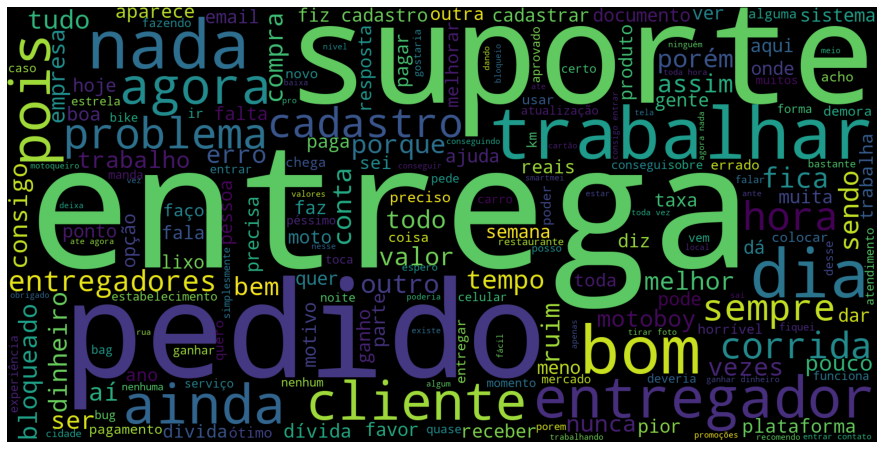

In [45]:
#Criando o objeto wordcloud com as configs necessárias. Cor escolhida = preta, origem dos dados = all_content
wordcloud = WordCloud(stopwords=stopwords,background_color='black', width=1600,height=800).generate(all_content)
#configurando forma de apresentação do gráfico e apresentando no notebook.
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [46]:
#Criando agora um Dataset apenas com o que vamos usar no modelo. Não preciso incluir nenhum detalhe sobre quem deu o review.
Rappi = Reviews_Rappi[['content', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'score',  'Score_Sentimento', 'Sent']]

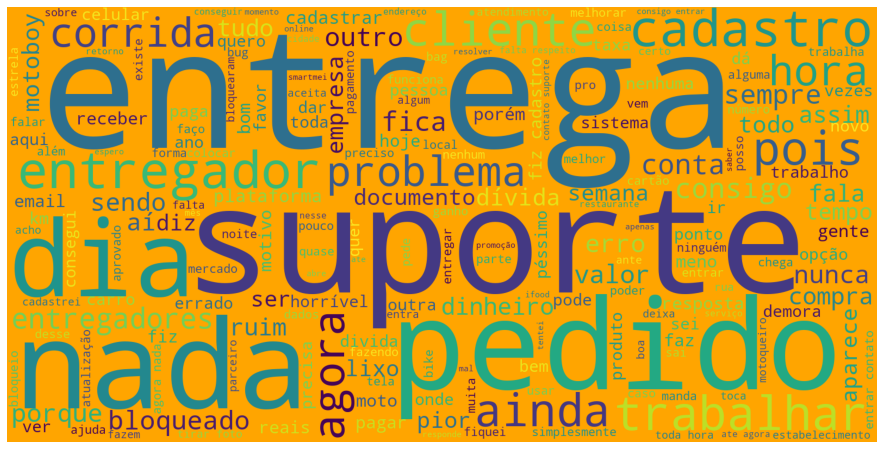

In [47]:
#Realizando o mesmo processo, porém agora para avaliações negativas - notas 1 e 2
Negative = Rappi[Rappi.score < 3]
Neg_Content = Negative['content']
all_neg_content = "".join(c for c in Neg_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='orange', width=1600,                            
                      height=800).generate(all_neg_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

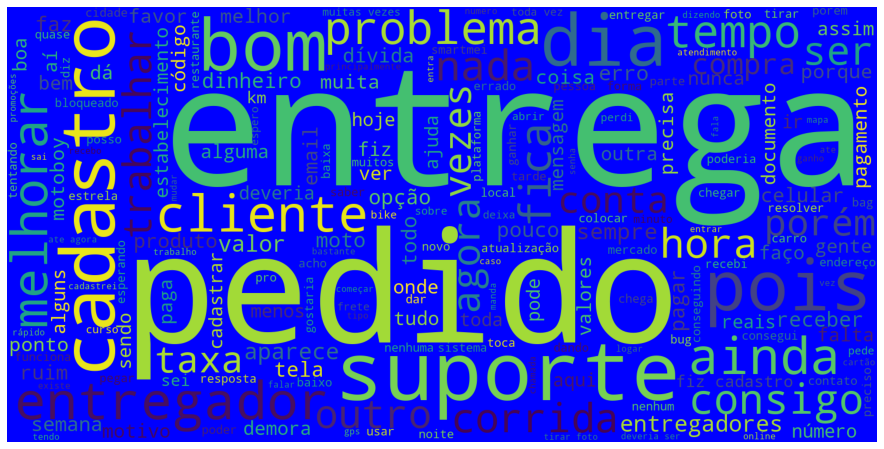

In [48]:
#Realizando o mesmo procedimento, para avaliações consideradas neutras (Nota = 3)
Neutral = Rappi[Rappi.score == 3]
Neu_Content = Neutral['content']
all_neu_content = "".join(c for c in Neu_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='blue', width=1600,                            
                      height=800).generate(all_neu_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

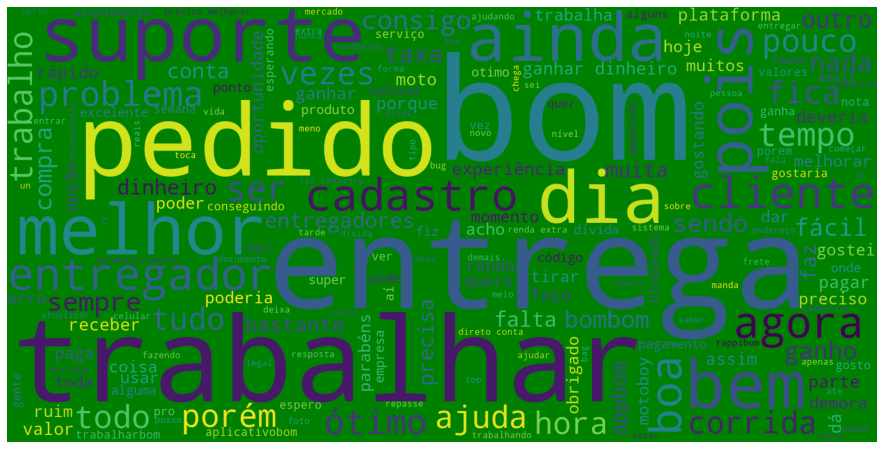

In [49]:
#Finalmente, realizando o procedimento para notas chamadas Positivas, (4 e 5)
Positive = Rappi[Rappi.score > 3]
Pos_Content = Positive['content']
all_pos_content = "".join(c for c in Pos_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='green', width=1600,                            
                      height=800).generate(all_pos_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [50]:
# Vetorização (Converter texto e números).
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(max_features=1000)                
data_features = vectorizer.fit_transform(Rappi['content'])


data_features = data_features.toarray()       

In [51]:
labels = Rappi['score'].values

In [52]:
# Split data into training and testing set.


from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [53]:
# Usando Random Forest para classificar os reviews.
# Também calculando o Score Cross Validated.


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


forest = RandomForestClassifier(n_estimators=10, n_jobs=4)


forest = forest.fit(X_train, y_train)


print(forest)


print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7168835960583151


[[2942  104  124   56  407]
 [ 504   25   39   24  110]
 [ 489   37   82   78  338]
 [ 200   22   56   67  733]
 [ 500   36   87  166 7867]]


Text(0.5, 1.0, 'Confusion Matrix para Modelo Random Forest')

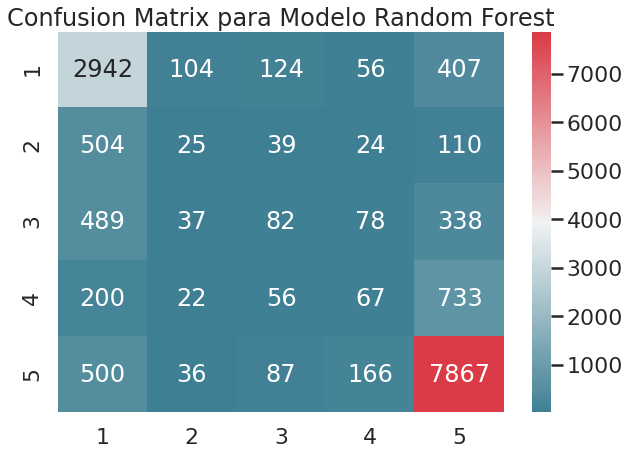

In [54]:
result = forest.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set("poster")
sns.set_style('whitegrid')
conf_mat = confusion_matrix(y_test, result)
cmap = sns.diverging_palette(220, 10, as_cmap = True)
print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm,cmap=cmap, annot=True, fmt='g').set_title('Confusion Matrix para Modelo Random Forest')

In [55]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(max_iter = 10000)

LogReg = LogReg.fit(X_train, y_train)

print(LogReg)

print(np.mean(cross_val_score(LogReg, data_features, labels, cv=10)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.7281339709704405


[[2799   98  146   53  537]
 [ 427   35   55   31  154]
 [ 418   34   94   77  401]
 [ 143   13   52   72  798]
 [ 304   20   69   93 8170]]


Text(0.5, 1.0, 'Confusion Matrix para Modelo Logistic Regression')

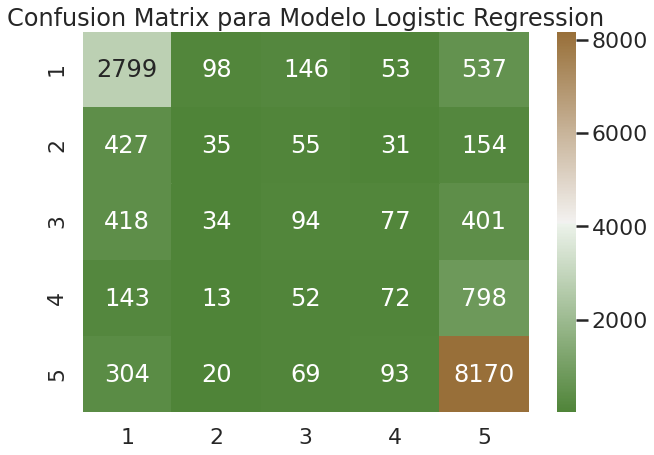

In [57]:
result_logreg = LogReg.predict(X_test)
conf_mat = confusion_matrix(y_test, result_logreg)

cmap = sns.diverging_palette(120, 50, as_cmap = True)
print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,cmap=cmap, annot=True, fmt='g').set_title('Confusion Matrix para Modelo Logistic Regression')

In [59]:
X = Rappi['content']
y = Rappi['score']
#Fazendo um novo split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
random_state = 42)

In [60]:
cvec = CountVectorizer(max_features = 1000).fit(X_train)
#Vamos chamar o primeiro train set de df_train
df_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
df_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)
print(y_test.shape)

(35215, 1000)
(35215,)
(15093, 1000)
(15093,)


In [61]:
X = Rappi['reviewCreatedVersion'].apply(str)
y = Rappi['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)

Version_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
Version_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

In [62]:
X = Rappi['thumbsUpCount'].apply(str)
y = Rappi['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)
Thumbs_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
Thumbs_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

In [64]:
X = Rappi['Sent'].apply(str)
y = Rappi['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)
Sent_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
Sent_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

In [66]:
X = Rappi['at'].apply(str)
y = Rappi['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)
at_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
at_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

In [67]:
train = pd.concat ([df_train, Sent_train, Thumbs_train, Version_train, at_train], axis = 1)
test = pd.concat([df_test, Sent_test, Thumbs_test, Version_test, at_test], axis = 1)
print(train.shape)
print(test.shape)
print(y_train.shape)
print(y_test.shape)

(35215, 1245)
(15093, 1245)
(35215,)
(15093,)


In [68]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(train, y_train)
print(forest)
print(np.mean(cross_val_score(forest,test, y_test, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7310003554829961


In [69]:
LogReg = LogisticRegression(max_iter = 10000)

LogReg = LogReg.fit(train, y_train)

print(LogReg)

print(np.mean(cross_val_score(LogReg, test, y_test, cv=10)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.731728481209871
